<a href="https://colab.research.google.com/github/Danollas/reinforcement-learning-danollas/blob/main/breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install "gym==0.22.0"
!pip install "gymnasium[atari]==0.26.1"
!pip install "stable-baselines[mpi]==2.10.0"
!pip install gym[accept-rom-license]
!pip install "ale-py==0.7.4"
!pip install ipywidgets
!apt-get install ffmpeg


  Using cached ale_py-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.7.4
    Uninstalling ale-py-0.7.4:
      Successfully uninstalled ale-py-0.7.4


  Using cached ale_py-0.7.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.8.1
    Uninstalling ale-py-0.8.1:
      Successfully uninstalled ale-py-0.8.1


  Using cached ale_py-0.7.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.7.5
    Uninstalling ale-py-0.7.5:
      Successfully uninstalled ale-py-0.7.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [19]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from google.colab import drive
import gym.wrappers
import gym
from moviepy.editor import *

# Creating a folder in Google Disk
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


(210, 160, 3)


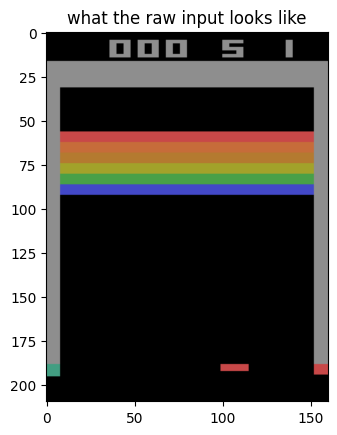

In [3]:
# Observations (raw)
env = make_atari("BreakoutNoFrameskip-v4")
obs = np.array(env.reset())
print(obs.shape)
plt.title("what the raw input looks like")
plt.imshow(obs)

(84, 84, 4)


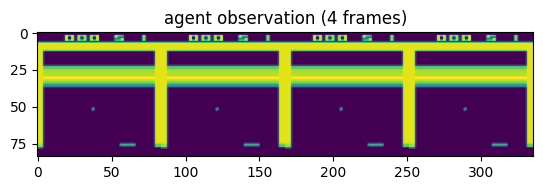

In [4]:
# Obseravtions (wrapped)
env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
obs = np.array(env.reset())

print(obs.shape)
plt.title("agent observation (4 frames)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))

In [5]:
# Actions
print(env.action_space)
print(env.get_action_meanings())

Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


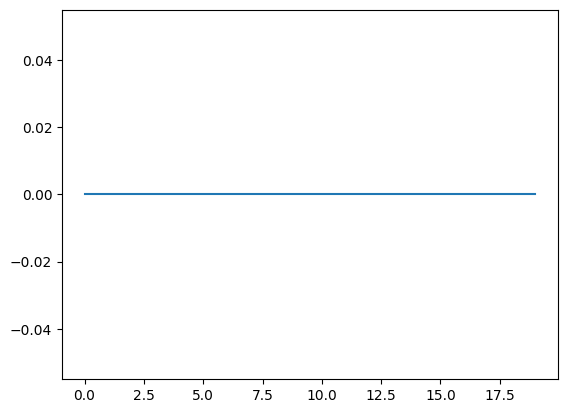

In [6]:
# Rewards
env.reset()
rewards = []
while True:
    obs, rew, done, info = env.step(env.action_space.sample())
    rewards.append(rew)
    if done:
        break
plt.plot(rewards)

In [7]:
num_actions = 4
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to make a action.
model = create_q_model()
# Target model
model_target = create_q_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052  

In [8]:
gamma = 0.99  # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0
epsilon_max_1 = 1.0
epsilon_min_1 = 0.2
epsilon_max_2 = epsilon_min_1
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 150000

# Size of batch taken from replay buffer
batch_size = 32
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 20

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

In [ ]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []

episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):

        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        if frame_count < epsilon_greedy_frames:
          epsilon -= epsilon_interval_1 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_1)

        if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_2 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_2)

        if frame_count > 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_3 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_3)


        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every 20th frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 12:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

In [9]:
# # Saving the model
model_name = 'breakout_model_1'
path = F"/content/gdrive/MyDrive/models/{model_name}"
# model.save(path)

# Loading the model
model = tf.keras.models.load_model(path)

In [10]:
def make_env():
  env = make_atari("BreakoutNoFrameskip-v4")
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  return env

Lost one life after 973 timesteps
{'lives': 4, 'episode_frame_number': 3900, 'frame_number': 3900}


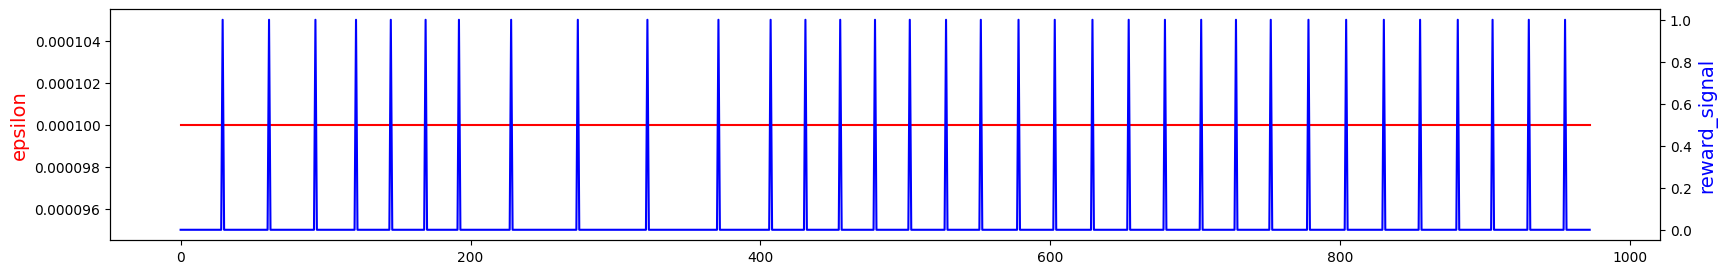

Bricks left to destroy  74.0
Lost one life after 1562 timesteps
{'lives': 3, 'episode_frame_number': 6268, 'frame_number': 6268}


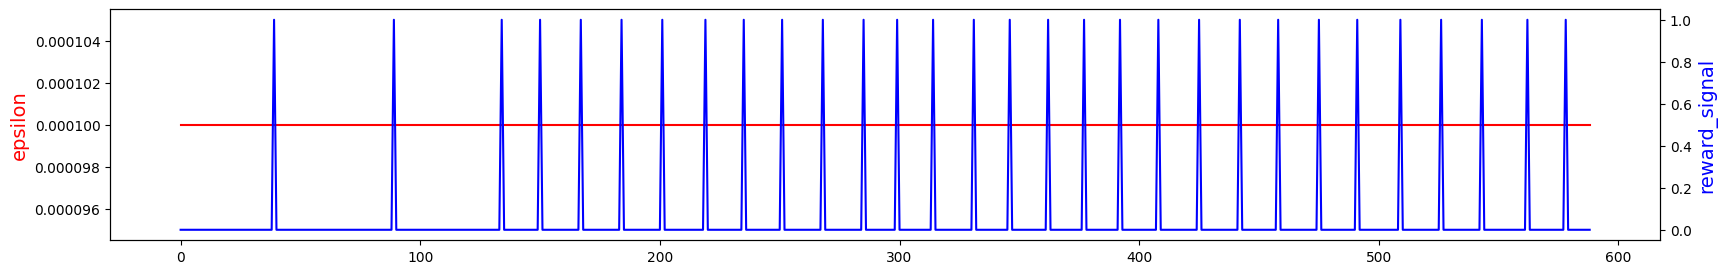

Bricks left to destroy  44.0
Lost one life after 1767 timesteps
{'lives': 2, 'episode_frame_number': 7100, 'frame_number': 7100}


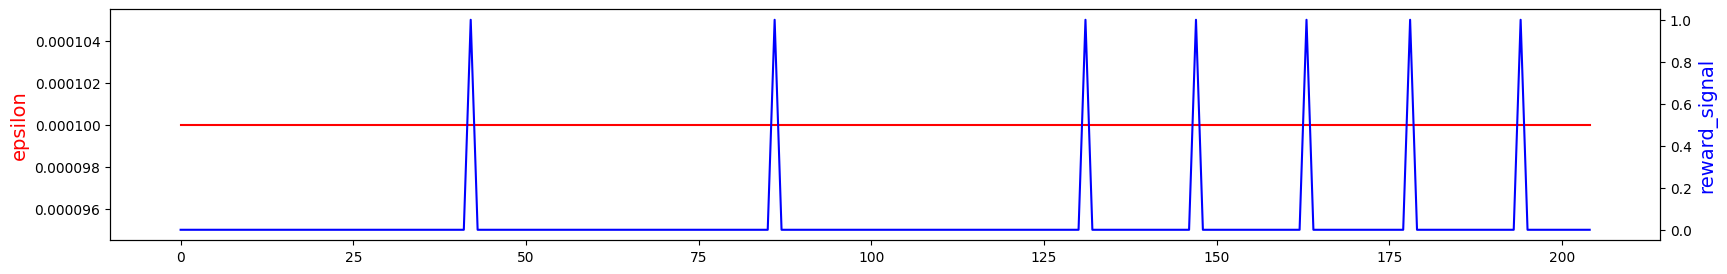

Bricks left to destroy  37.0
Lost one life after 1984 timesteps
{'lives': 1, 'episode_frame_number': 7980, 'frame_number': 7980}


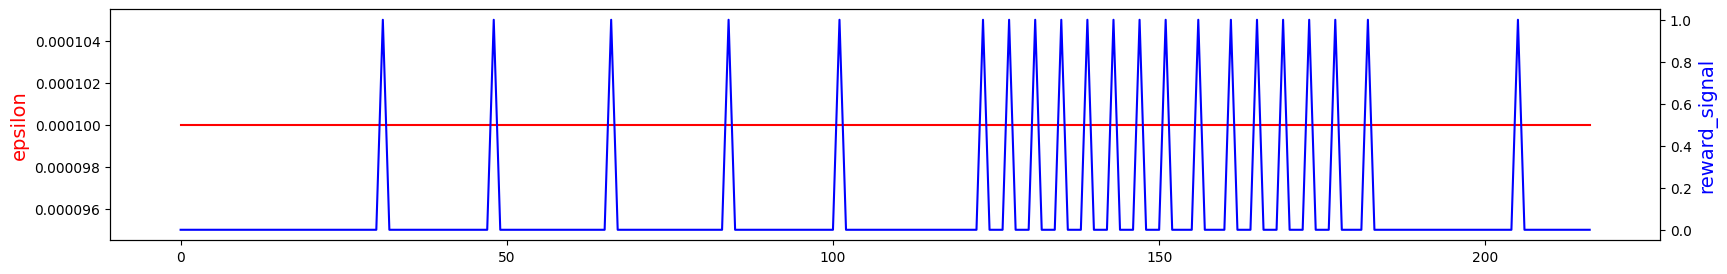

Bricks left to destroy  16.0
Lost one life after 2045 timesteps
{'lives': 0, 'episode_frame_number': 8232, 'frame_number': 8232}


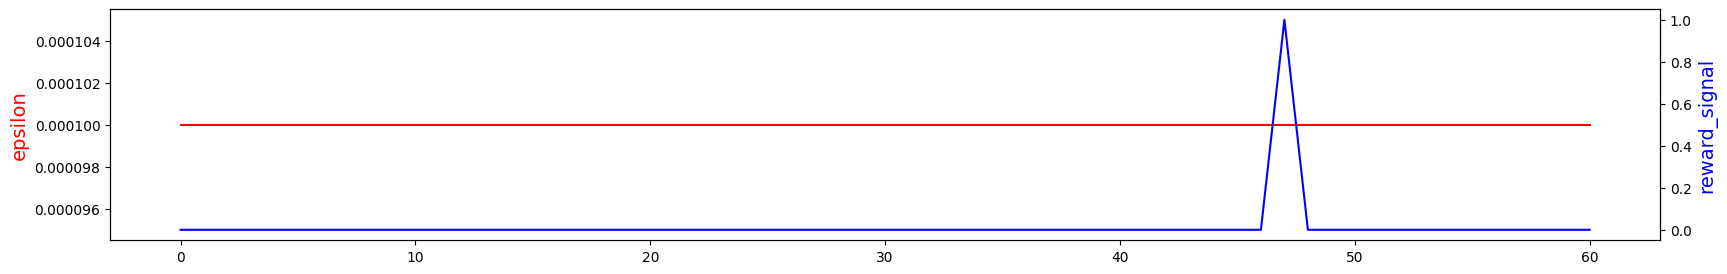

Bricks left to destroy  15.0


In [17]:
env = make_env()
env = gym.wrappers.Monitor(env, "./vid1", force=True, video_callable=lambda episode_id: True)

observation = env.reset()
info = 0
reward_window = []
reward_signal_history = []
epsilon_history = []

hits = []
bltd = 108 #total bricks to destroy

for i_episode in range(1):
    reward_window=[]
    epsilon = 0
    for t in range(4000):

        if epsilon > np.random.rand(1)[0]:
          action = np.random.choice(num_actions)
        else:
          state_tensor = tf.convert_to_tensor(observation)
          state_tensor = tf.expand_dims(state_tensor, 0)
          action_probs = model(state_tensor, training=False)
          action = tf.argmax(action_probs[0]).numpy()

        observation, reward, done, info = env.step(action)
        hits.append(reward)
        reward_window.append(reward)
        if len(reward_window) > 200:
          del reward_window[:1]
        if len(reward_window) == 200 and np.sum(reward_window) == 0:
          epsilon = 0.01
        else:
          epsilon = 0.0001

        epsilon_history.append(epsilon)
        reward_signal_history.append(reward)


        if done:
            print("Lost one life after {} timesteps".format(t+1))
            print(info)
            # Plot epsilon and reward signal
            fig,ax=plt.subplots(figsize=(20,3))
            #plt.clf()
            ax.plot(epsilon_history, color="red")
            ax.set_ylabel("epsilon",color="red",fontsize=14)
            ax2=ax.twinx()
            ax2.plot(reward_signal_history,color="blue")
            ax2.set_ylabel("reward_signal",color="blue",fontsize=14)
            plt.show()

            epsilon_history = []
            reward_signal_history = []

            bltd = bltd-np.sum(hits)
            hits = []
            print("Bricks left to destroy ", bltd)
            if info['lives'] == 0:
              break

            env.reset()
env.close()

In [23]:
import os
from moviepy.editor import *

# Get a list of all the .mp4 files in the vid1 folder
video_files = [f for f in os.listdir('./vid1') if f.endswith('.mp4')]

# Sort the video files to ensure they are in the correct order
video_files.sort()

# Load and concatenate videos
clips = [VideoFileClip(os.path.join('./vid1', f)) for f in video_files]
concat_clip = concatenate_videoclips(clips, method="compose")

# Write the result to a file
concat_clip.write_videofile("output.mp4", codec="libx264")

# Optionally, close all clips to free up memory
for clip in clips:
    clip.close()


Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



t:  43%|████▎     | 877/2051 [00:00<00:00, 1747.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./vid1/openaigym.video.6.44743.video000000.mp4, 100800 bytes wanted but 0 bytes read,at frame 974/975, at time 32.47/32.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                                  

Moviepy - Done !
Moviepy - video ready output.mp4


MoviePy - Building file output.gif with imageio.



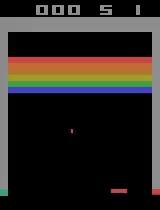

In [30]:
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
import base64

# Load the video file
video_clip = VideoFileClip("output.mp4")

# Convert the video to a GIF and save it to a file
gif_filename = "output.gif"
video_clip.write_gif(gif_filename, fps=10)  # Adjust fps value as needed

# Display the GIF
with open(gif_filename, "rb") as f:
    display(HTML(f'<img src="data:image/gif;base64,{base64.b64encode(f.read()).decode()}" />'))
